Import IDC images from local drive

In [66]:
#Import relevant packages
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from skimage.io import imread
from PIL import Image
import fnmatch
import cv2
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
#Import data from local drive
files = os.listdir('C:/Users/benja/Dropbox/Ben Code/Springboard not GIT linked/IDC_image_data/breast-histopathology-images')
print(len(files))
base_path = 'C:/Users/benja/Dropbox/Ben Code/Springboard not GIT linked/IDC_image_data/breast-histopathology-images/IDC_regular_ps50_idx5/'
folder = os.listdir(base_path)

280


We have 280 folders, the releventdata all seems to be held in the IDC_regular_ps50_idx5 folder, so I've made that the base_path for easy reference. Next lets pull patient ID into a workable object and determine how many images we're working with

In [3]:
#Create patient_ID object and count total number of patches(portions of image slides)
total_images = 0
for n in range(len(folder)):
    patient_ID = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_ID 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        total_images += len(subfiles)
               
print(total_images)

277524


Wow, almost 280,000 patches to work through! Next, let's build a dataframe to work with that includes if IDC is present in that patch (0-absent, 1-present).

In [4]:
#Build a dataframe
df = pd.DataFrame(index = np.arange(0,total_images), columns = ['patient_ID','path', 'image_ID', 'IDC'])

k = 0
for n in range(len(folder)):
    patient_ID = folder[n]
    patient_path = base_path + patient_ID 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            df.iloc[k]["path"] = class_path + image_path
            df.iloc[k]["image_ID"] = image_path
            df.iloc[k]["IDC"] = c
            df.iloc[k]["patient_ID"] = patient_ID
            k += 1

In [25]:
df['label'] = np.where(df['IDC'] == 0, 'neg', 'pos')

df.head()

,patient_ID,path,image_ID,IDC,label
0,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,10253_idx5_x1001_y1001_class0.png,0,neg
1,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,10253_idx5_x1001_y1051_class0.png,0,neg
2,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,10253_idx5_x1001_y1101_class0.png,0,neg
3,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,10253_idx5_x1001_y1151_class0.png,0,neg
4,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,10253_idx5_x1001_y1201_class0.png,0,neg


Perfect! Now let's take a look at some of our data distributions - how many patches do we have per patient? How many images have IDC visible? What fraction of those images is covered by a tumor?

C:\Users\benja\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


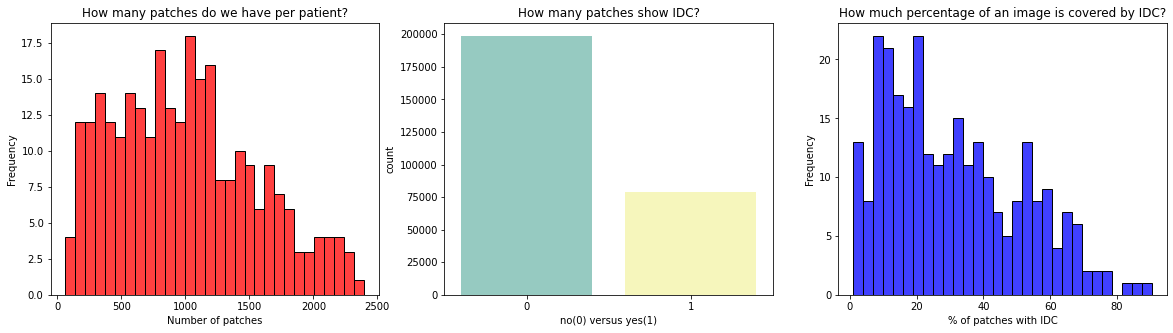

In [6]:
cancer_perc = df.groupby("patient_ID").IDC.value_counts()/ df.groupby("patient_ID").IDC.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.histplot(df.groupby("patient_ID").size(), ax=ax[0], color="red", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.countplot(df.IDC, palette="Set3", ax=ax[1]);
ax[1].set_xlabel("no(0) versus yes(1)")
ax[1].set_title("How many patches show IDC?");
sns.histplot(cancer_perc.loc[:, 1]*100, ax=ax[2], color="blue", kde=False, bins=30)
ax[2].set_title("How much percentage of an image is covered by IDC?")
ax[2].set_ylabel("Frequency")
ax[2].set_xlabel("% of patches with IDC");

OK, so pretty good range of patch counts per patient, looks like some patches are over 80% IDC tumors, and the majority of patches don't contain IDC tumors. Let's look at what these patches actually look like!

In [7]:
#First we'll randomly select 25 patches of both IDC positive and negative images:
df.IDC = df.IDC.astype(np.int)

pos_selection = np.random.choice(df[df.IDC==1].index.values, size=25, replace=False)
neg_selection = np.random.choice(df[df.IDC==0].index.values, size=25, replace=False)

Next we'll build some subplots to show the randomly selected slides

Positive

In [ ]:
#Next we'll build some subplots to show those randomly selected slides

fig, ax = plt.subplots(5,5,figsize=(20,10))

for n in range(5):
    for m in range(5):
        idx = pos_selection[m + 5*n]
        image = imread(df.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Negative

In [ ]:
fig, ax = plt.subplots(5,5,figsize=(20,10))

for n in range(5):
    for m in range(5):
        idx = neg_selection[m + 5*n]
        image = imread(df.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Next lets adjust the pixel values of each image to be between 0 and 1, this will help for standardizing images before we start training models.

In [ ]:
#first load all images and resize them to standard sizes

resized_image =[]
images = glob(r'C:/Users/benja/Dropbox/Ben Code/Springboard not GIT linked/IDC_image_data/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for img in images:
        full_size_image = cv2.imread(img)
        resized_image.append(cv2.resize(full_size_image, (50,50), interpolation=cv2.INTER_CUBIC))

In [ ]:
#Next we're going to convert the pixel values to be between 0 and 1 for faster processing later on - most pixel values are between 0 and 255 so we'll just divide them by 255
scaled_image = np.array(resized_image) #create an array of pixel values for each image from resized_image
scaled_image = scaled_image/255 #scale the pixel values to be between 0 and 1 for faster analysis
print(np.max(scaled_image[0])) #check images for any values over 1

In [ ]:
print('class0.png' in scaled_image)
print('class1.png' in scaled_image)

### Begin EDA

We're going to start our exploratory data analysis by creating a binary visualization of our images of tissue samples, then reconstruct some of the full tissue images.

In [8]:
def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_ID):
    df_0 = get_cancer_dataframe(patient_ID, "0")
    df_1 = get_cancer_dataframe(patient_ID, "1")
    patient_df = df_0.append(df_1)
    return patient_df

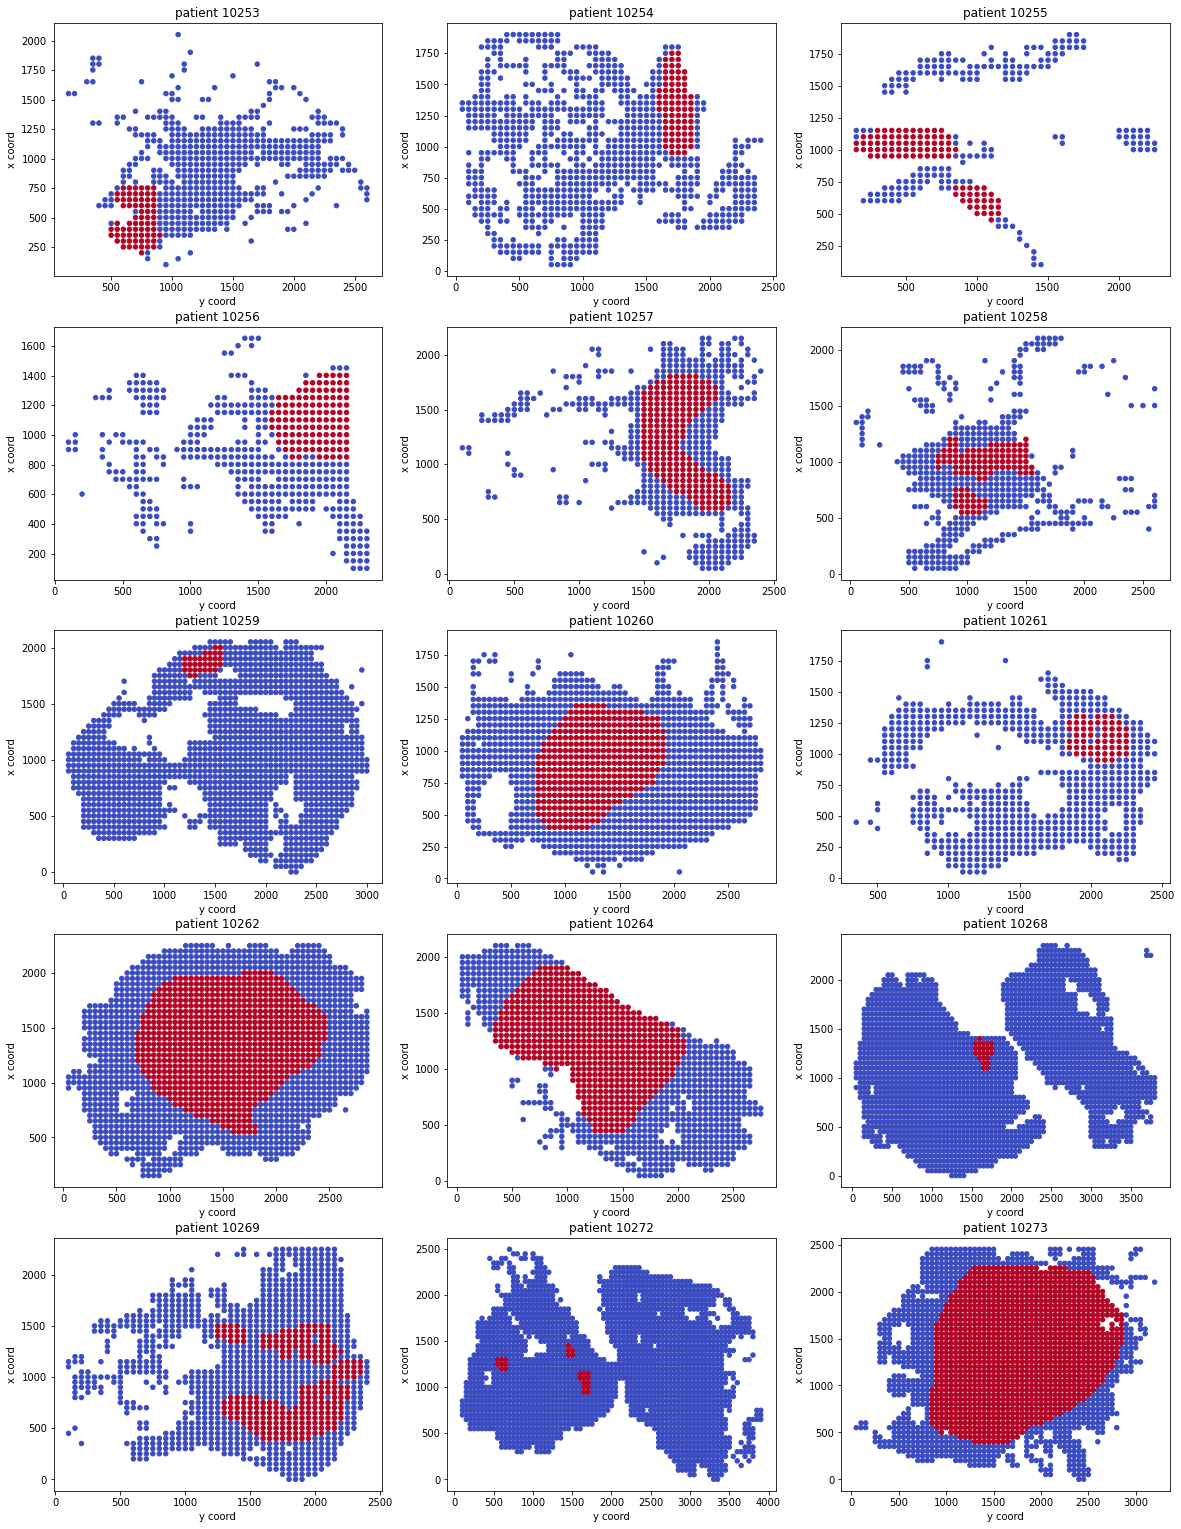

In [9]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = df.patient_ID.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

The above images show full tissue samples of patients, and there are a two main take-aways here. First, the red dots are slices that contain cancerous cells, while blue dots do not. Second, we can see that for some of these we have incomplete tissue sample images. This should not impact our goal of creating an effective CNN to detect cancerous cells from tissue sample images, but it is worth noting that in a way we're working with an incomplete data set.

Next let's visualize a full tissue sample of a patient. 

In [10]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

In [ ]:
#Lets run an example on patient 10257

example = "10257"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

The above images show the same sample reconstructed from our partial images provided. The image on the left is the "raw" image, unaltered and simply assembled. The image on the right, however has cancerous regions coded in red. It's difficult to discern any pattern here, apart from cancer seems to only appear in purple-hued regions. Perhaps these contain a higher concentration of mammary ducts? Additionally, I chose this patient to reitterate and better illustrate that we don't have complete images for all patients. These assembled images show clearly the kinds of data we're working with here. Again, this shouldn't impact our CNN, but it is something to be aware of.

## Prep data for Convolutional Neural Network

We'll split the data into two groups, training and testing along an 80/20 split.

Due to the imbalance of our data set (we have almost 3 times as many non-cancerous images) we will assign class weights with tensorflow to correct for this rather than reducing our data set.
We will use flow from dataframe in tensorflow to match the IDC positive and negative values held in the IDC column of our dataframe - note we could also reference class 1 and class 0 values in our image IDs.

In [26]:
#Split the data into 80/20 train/test
y = df['IDC']

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, random_state = 42)

print(X_train.head(), y_train.head())

       patient_ID                                               path  \
92758       12898  C:/Users/benja/Dropbox/Ben Code/Springboard no...   
233995       9125  C:/Users/benja/Dropbox/Ben Code/Springboard no...   
196679       8863  C:/Users/benja/Dropbox/Ben Code/Springboard no...   
177928      15902  C:/Users/benja/Dropbox/Ben Code/Springboard no...   
169919      15513  C:/Users/benja/Dropbox/Ben Code/Springboard no...   

                                 image_ID  IDC label  
92758     12898_idx5_x651_y151_class0.png    0   neg  
233995   9125_idx5_x1351_y1401_class1.png    1   pos  
196679    8863_idx5_x1651_y901_class0.png    0   neg  
177928  15902_idx5_x2551_y1501_class1.png    1   pos  
169919   15513_idx5_x1001_y651_class0.png    0   neg   92758     0
233995    1
196679    0
177928    1
169919    0
Name: IDC, dtype: int32


### Begin building CNN

In [40]:
num_train_samples = len(X_train)
num_test_samples = len(X_test)
train_batch_size = 10
test_batch_size = 10

train_steps = np.ceil(num_train_samples / train_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

In [41]:
image_size = 50
batch_size = 10

datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_dataframe(X_train, x_col = 'path', y_col = 'label', 
                                        target_size=(image_size, image_size), 
                                        batch_size=batch_size, 
                                        class_mode='categorical')

val_gen = datagen.flow_from_dataframe(X_test, x_col = 'path', y_col = 'label',
                                        target_size=(image_size,image_size),
                                        batch_size=batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_dataframe(X_test, x_col = 'path', y_col = 'label',
                                        target_size=(image_size,image_size),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 222019 validated image filenames belonging to 2 classes.
Found 55505 validated image filenames belonging to 2 classes.
Found 55505 validated image filenames belonging to 2 classes.


In [42]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (image_size, image_size, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 18, 18, 64)       

In [43]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [44]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'neg': 0, 'pos': 1}


In [45]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy
                             ', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=test_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)


C:\Users\benja\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
22202/22202 [==============================] - 4217s 190ms/step - loss: 0.4224 - accuracy: 0.8164 - val_loss: 0.3512 - val_accuracy: 0.8474
Epoch 2/20
22202/22202 [==============================] - 4997s 225ms/step - loss: 0.3468 - accuracy: 0.8523 - val_loss: 0.3234 - val_accuracy: 0.8610
Epoch 3/20
22202/22202 [==============================] - 5070s 228ms/step - loss: 0.3261 - accuracy: 0.8629 - val_loss: 0.3197 - val_accuracy: 0.8635
Epoch 4/20
22202/22202 [==============================] - 5130s 231ms/step - loss: 0.3152 - accuracy: 0.8685 - val_loss: 0.3370 - val_accuracy: 0.8557
Epoch 5/20
22202/22202 [==============================] - 3179s 143ms/step - loss: 0.3094 - accuracy: 0.8710 - val_loss: 0.3032 - val_accuracy: 0.8740
Epoch 6/20
22202/22202 [==============================] - 3684s 166ms/step - loss: 0.3010 - accuracy: 0.8735 - val_loss: 0.2930 - val_accuracy: 0.8774
Epoch 7/20
22202/22202 [==============================] - 3503s 158ms/step - loss: 0.2982 - ac

In [54]:
epoch_vals = list(np.arange(1,21))
train_loss = [0.4224, 0.3468, 0.3261, 0.3152, 0.3094, 0.3010, 0.2982, 0.2921, 0.2869, 0.2830, 0.2796, 0.2788, 0.2750, 0.2711, 0.2719, 0.2681, 0.2780, 0.2609, 0.2640, 0.2617]
train_accuracy = [0.8164, 0.8523, 0.8629, 0.8685, 0.8710, 0.8735, 0.8752, 0.8780, 0.8798, 0.8827, 0.8829, 0.8843, 0.8846, 0.8880, 0.8868, 0.8889, 0.8841, 0.8918, 0.8899, 0.8913]
test_loss = [0.3512, 0.3234, 0.3197, 0.3370, 0.3032, 0.2930, 0.3047, 0.2944, 0.3042, 0.2791, 0.2885, 0.2772, 0.2685, 0.2902, 0.2704, 0.3711, 0.2672, 0.2920, 0.2868, 0.2945]
test_accuracy = [0.8474, 0.8610, 0.8635, 0.8557, 0.8740, 0.8774, 0.8723, 0.8786, 0.8706, 0.8834, 0.8767, 0.8827, 0.8873, 0.8773, 0.8890, 0.8410, 0.8864, 0.8757, 0.8765, 0.8768]

test_train_perf_df = pd.DataFrame(index = np.arange(1,21), columns = ['epoch_vals', 'train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])
test_train_perf_df.epoch_vals = epoch_vals
test_train_perf_df.train_loss = train_loss
test_train_perf_df.train_accuracy = train_accuracy
test_train_perf_df.test_loss = test_loss
test_train_perf_df.test_accuracy = test_accuracy
print(test_train_perf_df)

    epoch_vals  train_loss  train_accuracy  test_loss  test_accuracy
1            1      0.4224          0.8164     0.3512         0.8474
2            2      0.3468          0.8523     0.3234         0.8610
3            3      0.3261          0.8629     0.3197         0.8635
4            4      0.3152          0.8685     0.3370         0.8557
5            5      0.3094          0.8710     0.3032         0.8740
6            6      0.3010          0.8735     0.2930         0.8774
7            7      0.2982          0.8752     0.3047         0.8723
8            8      0.2921          0.8780     0.2944         0.8786
9            9      0.2869          0.8798     0.3042         0.8706
10          10      0.2830          0.8827     0.2791         0.8834
11          11      0.2796          0.8829     0.2885         0.8767
12          12      0.2788          0.8843     0.2772         0.8827
13          13      0.2750          0.8846     0.2685         0.8873
14          14      0.2711        

In [56]:
# get the metric names so we can use evaulate_generator
model.metrics_names

# Here the best epoch will be used.

#model.load_weights('model.h5')

val_loss, val_accuracy = \
model.evaluate_generator(test_gen, 
                        steps=len(X_test))

print('val_loss:', val_loss)
print('val_acc:', val_accuracy)

C:\Users\benja\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.29446879029273987
val_acc: 0.8768219351768494


In [ ]:
test_train_perf_df['model_perf'] = 

<Figure size 432x288 with 0 Axes>

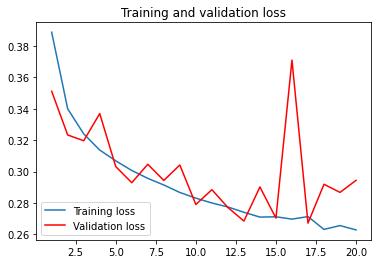

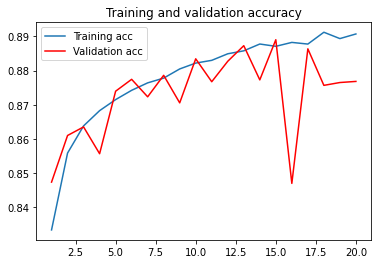

<Figure size 432x288 with 0 Axes>

In [57]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss', color='red')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc', color='red')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [58]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(X_test), verbose=1)

C:\Users\benja\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


55505/55505 [==============================] - 206s 4ms/step


In [59]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['IDC_neg', 'IDC_pos'])

df_preds.head()

,IDC_neg,IDC_pos
0,0.874688,0.125312
1,0.999449,0.000551
2,0.398726,0.601274
3,0.373532,0.626468
4,0.390931,0.609069


In [60]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['IDC_pos']

In [61]:
#Calculate AUC score
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9326589990529275

In [62]:
#Create a confusion matrix
test_labels = test_gen.classes

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

# Print the label associated with each class
test_gen.class_indices

{'neg': 0, 'pos': 1}

In [64]:
#Create a classification report

from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

                precision    recall  f1-score   support

 no_met_tissue       0.92      0.91      0.91     39866
has_met_tissue       0.77      0.79      0.78     15639

      accuracy                           0.88     55505
     macro avg       0.85      0.85      0.85     55505
  weighted avg       0.88      0.88      0.88     55505

